# The Deconfounder in Action

In this notebook, we are going to see **the deconfounder in action**.

We will perform **causal inference** with the deconfounder on a **breast cancer** dataset.

**Goal:**
To convince all of us that the deconfounder is **easy** to use!


The **deconfounder** operates in three steps:

1.   **Fit** a factor model to the assigned causes; it leads to a candidate substitute confounder.
2.   **Check** the factor model with a predictive check.
3.   **Correct** for the substitute confounder in a causal inference.


Let's get started!


# Getting ready to work!

In [2]:
!pip install tensorflow_probability==0.7
%pip install statsmodels==0.13.4

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

/Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chrissssssy/CSC254

In [5]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages
Requires: absl-py, astor, gast, google-pasta, grpcio, keras-applications, keras-preprocessing, numpy, protobuf, six, tensorboard, tensorflow-estimator, termcolor, wheel, wrapt
Required-by: 


In [6]:
!pip show tensorflow_probability

Name: tensorflow-probability
Version: 0.7.0
Summary: Probabilistic modeling and statistical inference in TensorFlow
Home-page: http://github.com/tensorflow/probability
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages
Requires: cloudpickle, decorator, numpy, six
Required-by: 


In [7]:
# set random seed so everyone gets the same number
import random
randseed = 123
print("random seed: ", randseed)
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)

random seed:  123



## The scikit-learn breast cancer dataset

*   It is a data set about **breast cancer**. 
*   We are interested in how tumor properties **affect** cancer diagnosis. 
*   The **(multiple) causes** are tumor properties, e.g. sizes, compactness, symmetry, texture. 
*   The **outcome** is tumor diagnosis, whether the breast cancer is diagnosed as malignant or benign.



In [8]:
data = load_breast_cancer()

In [9]:
print(data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

***For simplicity, we will work with the first 10 features, i.e. the mean radius/texture/perimeter***/....

In [10]:
num_fea = 10
df = pd.DataFrame(data["data"][:,:num_fea], columns=data["feature_names"][:num_fea])

In [11]:
df.shape

(569, 10)

In [12]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [13]:
dfy = data["target"]

In [14]:
dfy.shape, dfy[:100] # binary outcomes

((569,),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]))

## Preparing the dataset for the deconfounder

### Only one step of preprocessing needed!

### We need to get rid of the highly correlated causes

**Why** do we need to get rid of highly correlated causes?

If two causes are **highly correlated**, a valid substitute confounder will largely **inflate the variance** of causal estimates downstream.

This phenomenon is **closely related to** the variance inflation phenomenon in linear regression.





***A more technical explanation (ignorable)***

Think of the extreme case where two causes are perfectly collinear $A_1 = 5A_2$. The only random variable Z that 
$$A_1 \perp A_2 | Z,$$

$(A_1, A_2)$ **must** be a **deterministic function** of Z. For example, $Z = A_1$ or $Z = A_2$.

Such a substitute confounder Z **breaks one of the conditions** the deconfounder requires. See "***A note on overlap***" in the theory section of the paper.


**How** do we get rid of highly correlated causes?

*   We first make a **scatter plot** of **all pairs** of the causes.

*   It reveals which causes are **highly correlated**.

*   We will **exclude** these highly correlated causes by hand.



/Users/chrissssssy/CSC2541-Course-Project/lib/python3.7/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


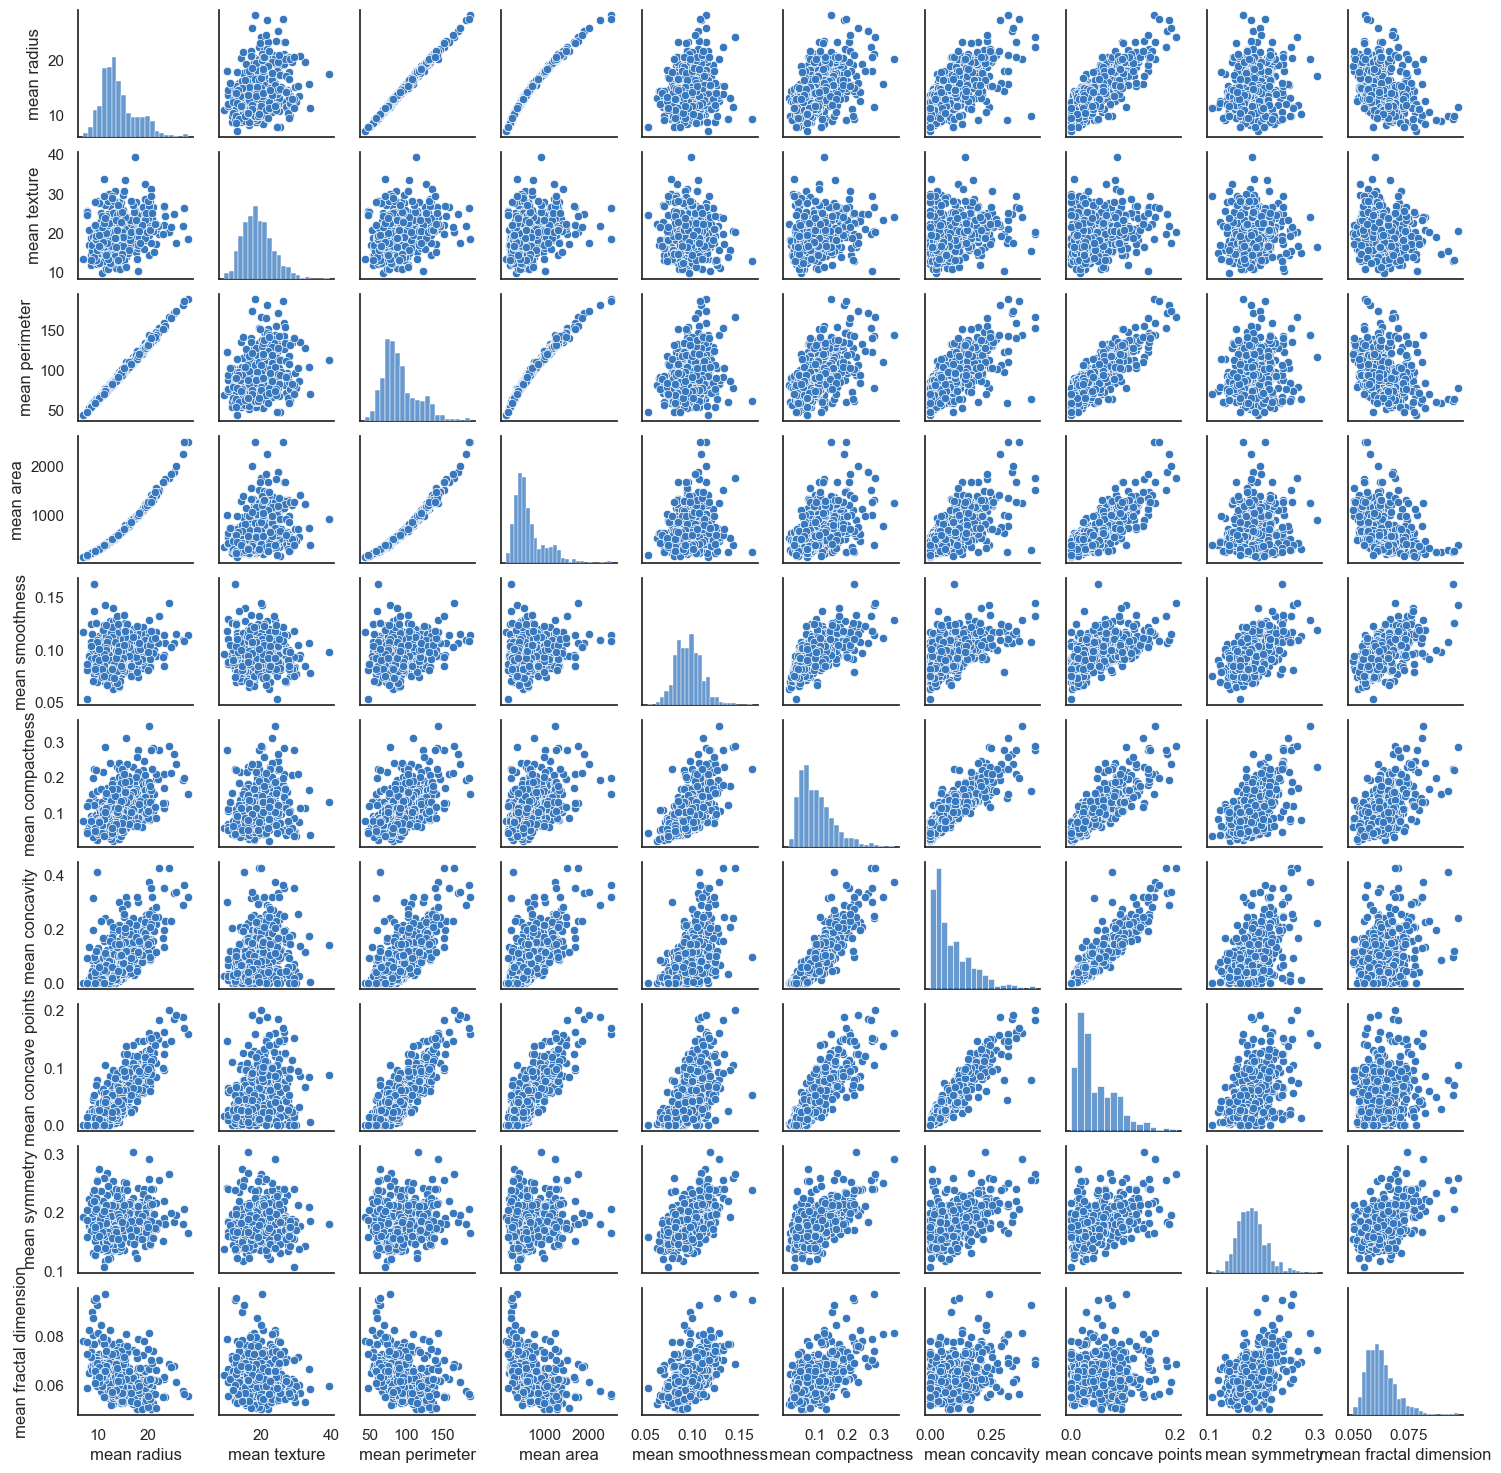

In [15]:
sns.pairplot(df, size=1.5)

In [16]:
# perimeter and area are highly correlated with radius
fea_cols = df.columns[[(not df.columns[i].endswith("perimeter")) \
                     and (not df.columns[i].endswith("area")) \
                     for i in range(df.shape[1])]]

In [17]:
dfX = pd.DataFrame(df[fea_cols])

print(dfX.shape, dfy.shape)

(569, 8) (569,)


### How does the dataset look like after preprocessing?

In [18]:
# The causes
dfX.head()

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [19]:
# The outcome
dfy[:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0])

# The dataset is ready. Let's do causal inference with the deconfounder!

## Step 1: Fit a factor model to the assigned causes; it leads to a substitute confounder.


### We start with trying out a random factor model. How about a probabilistic PCA model?

The matrix of assigned causes $X$

*   It has N=569 rows and D=8 columns. 
*   N is the number of subjects/data points.
*   D is the number of causes/data dimension.

### Step 1.1: Some chores first...

#### Standardize the data
This step is optional to the deconfounder. 

It only makes finding a good probabilistic PCA model easier.

In [20]:
# dfX.std()

In [21]:
# standardize the data for PPCA
X = np.array((dfX - dfX.mean())/dfX.std())

#### Then holdout some data!

We will later need to check the factor model with some heldout data.
So let's holdout some now.

In [22]:
# randomly holdout some entries of X
num_datapoints, data_dim = X.shape

holdout_portion = 0.2
n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)
holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                            (holdout_row, holdout_col)), \
                            shape = X.shape)).toarray()

holdout_subjects = np.unique(holdout_row)
holdout_mask = np.minimum(1, holdout_mask)

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

### Step 1.2: We are ready to fit a probabilistic PCA model to x_train.

This step of "**fitting** a factor model" involves **inferring latent variables** in probability models. 

We will rely on **Tensorflow Probability**, a library for probabilistic reasoning and statistical analysis in TensorFlow.

There are many **other probabilistic programming toolboxes** for fitting factor models, e.g. Pyro, Stan. 

Some of the latent variable models can also be fit with **scikit-learn**. 

We are free to use any of these with the deconfounder!





**What does a probabilistic PCA model look like?**

*  Probabilistic PCA is a dimensionality reduction technique. It models data with a lower dimensional latent space.

*  We consider the assigned causes of the $n$th subject. We write it as $\mathbf{x}_n$, which is a $D=8$ dimensional vector.

*  The probabilistic PCA assumes the following data generating process for each $\mathbf{x}_n$, $n = 1, ..., N$:

\begin{equation*}
\mathbf{z}_{n} \stackrel{iid}{\sim} N(\mathbf{0}, \mathbf{I}_K),
\end{equation*}

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{z}_n\mathbf{W}, \sigma^2\mathbf{I}_D).
\end{equation*}


*  We construct a $K$-dimensional substitute confounder $\mathbf{z}_{n}$ for each subject $n$, $n = 1, ..., N$. 
*  Each $\mathbf{z}_{n}$ is a $K$-dimensional latent vector, $n = 1, ..., N$. 




In [23]:
# we allow both linear and quadratic model
# for linear model x_n has mean z_n * W
# for quadratic model x_n has mean b + z_n * W + (z_n**2) * W_2
# quadractice model needs to change the checking step accordingly

def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, mask, form="linear"):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    if form == "linear":
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    elif form == "quadratic":
        b = ed.Normal(loc=tf.zeros([1, data_dim]),
                scale=tf.ones([1, data_dim]),
                name="b")  # intercept
        w2 = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w2")  # quadratic parameter
        x = ed.Normal(loc=tf.multiply(b + tf.matmul(z, w) + tf.matmul(tf.square(z), w2), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

**Let's fit a probabilistic PCA model.**

In [24]:
latent_dim = 2
stddv_datapoints = 0.1

model = ppca_model(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints, 
                   mask=1-holdout_mask)

The cell below implements **variational inference** for probabilistic PCA  in tensorflow probability.

You are free to fit the probabilistic PCA in your favourite ways with your favourite package. 

Note: approximate inference is perfectly fine!

It is orthogonal to our discussion around the deconfounder.

Let's **ignore** that for now (and forever).


2022-11-20 00:32:39.700811: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


Inferred axes:
[[-0.20001684 -0.35624757  0.8716981   0.71408194  0.49893728  0.35944957
   0.8170083   1.0619057 ]
 [ 1.061294    0.732722    0.05906332  0.53727853  0.7492386   0.85624087
   0.09547903 -0.41260788]]
Standard Deviation:
[[0.0119634  0.01003199 0.00852257 0.00887887 0.01089753 0.01173203
  0.0086521  0.0106139 ]
 [0.00820457 0.00771081 0.00731847 0.00790125 0.00942543 0.00881849
  0.00864348 0.00923635]]


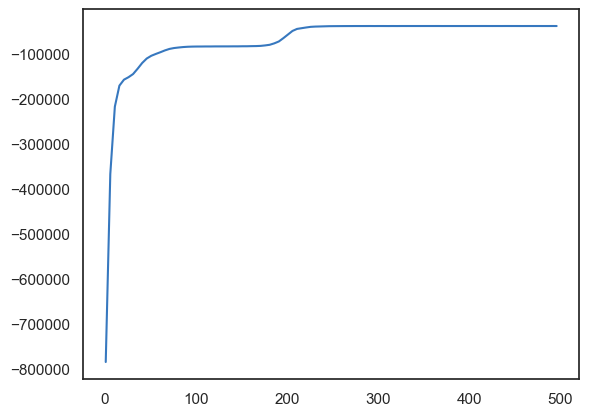

In [25]:
def variational_model(qb_mean, qb_stddv, qw_mean, qw_stddv, 
                      qw2_mean, qw2_stddv, qz_mean, qz_stddv):
    qb = ed.Normal(loc=qb_mean, scale=qb_stddv, name="qb")
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qw2 = ed.Normal(loc=qw2_mean, scale=qw2_stddv, name="qw2")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qb, qw, qw2, qz


log_q = ed.make_log_joint_fn(variational_model)

def target(b, w, w2, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   mask=1-holdout_mask,
                   w=w, z=z, w2=w2, b=b, x=x_train)

def target_q(qb, qw, qw2, qz):
    return log_q(qb_mean=qb_mean, qb_stddv=qb_stddv,
                 qw_mean=qw_mean, qw_stddv=qw_stddv,
                 qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                 qz_mean=qz_mean, qz_stddv=qz_stddv,
                 qw=qw, qz=qz, qw2=qw2, qb=qb)

qb_mean = tf.Variable(np.ones([1, data_dim]), dtype=tf.float32)
qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qw2_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
qb_stddv = tf.nn.softplus(tf.Variable(0 * np.ones([1, data_dim]), dtype=tf.float32))
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qw2_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

qb, qw, qw2, qz = variational_model(qb_mean=qb_mean, qb_stddv=qb_stddv,
                                    qw_mean=qw_mean, qw_stddv=qw_stddv,
                                    qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                                    qz_mean=qz_mean, qz_stddv=qz_stddv)


energy = target(qb, qw, qw2, qz)
entropy = -target_q(qb, qw, qw2, qz)

elbo = energy + entropy


optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 500

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_epochs):
        sess.run(train)
        if i % 5 == 0:
            t.append(sess.run([elbo]))

        b_mean_inferred = sess.run(qb_mean)
        b_stddv_inferred = sess.run(qb_stddv)
        w_mean_inferred = sess.run(qw_mean)
        w_stddv_inferred = sess.run(qw_stddv)
        w2_mean_inferred = sess.run(qw2_mean)
        w2_stddv_inferred = sess.run(qw2_stddv)
        z_mean_inferred = sess.run(qz_mean)
        z_stddv_inferred = sess.run(qz_stddv)
        
print("Inferred axes:")
print(w_mean_inferred)
print("Standard Deviation:")
print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

def replace_latents(b, w, w2, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "b":
            rv_kwargs["value"] = b
        elif name == "w":
            rv_kwargs["value"] = w
        elif name == "w":
            rv_kwargs["value"] = w2
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor

So we just played some **magic** to **fit the probabilistic PCA** to the matrix of assigned causes $\mathbf{X}$.


**The only important thing here is: **

We have **inferred** the latent variables $\mathbf{z}_n, n=1, ..., N$ and the parameters $\mathbf{W}$.

Specifically, we have obtained from this step

```
w_mean_inferred,
w_stddv_inferred,
z_mean_inferred,
z_stddv_inferred.
```



## Step 2: Check the factor model with a predictive check.


Now we are ready to **check** the probabilistic PCA model.

The checking step is **very important** to the deconfounder. 

Pleeeeeze **always** check the factor model!

**How** do we perform the predictive check?


1.  We will **generate** some replicated datasets for the heldout entries.
2.  And then **compare** the replicated datasets with the original dataset on the heldout entries.
3.  If they **look similar**, then we are good to go.



#### Step 2.1: We generate some replicated datasets first.

*  We will start with generating some **replicated datasets** from the predictive distribution of the assigned causes $X$:
\begin{align}
  p(\mathbf{X^{rep}_{n,heldout}} \,|\, \mathbf{X_{n, obs}}) =
  \int p(\mathbf{X_{n, heldout}} \,|\, \mathbf{z}_n) p(\mathbf{z_n} \,|\, \mathbf{X}_{n, obs}) \mathrm{d} \mathbf{z_n}.
\end{align}

*  That is, we generate these datasets from a probabilistic PCA model given the **inferred** latent variables $\hat{p}(\mathbf{z}_n)$ and $\hat{p}(\mathbf{W})$:

\begin{equation*}
\mathbf{z}_{n} \sim \hat{p}(\mathbf{z}_n),
\end{equation*}

\begin{equation*}
\mathbf{W} \sim \hat{p}(\mathbf{W}),
\end{equation*}

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{z}_n\mathbf{W}, \sigma^2\mathbf{I}_D).
\end{equation*}


*  These replicated datasets tell us what the assigned causes $X$ **should look like** if it is indeed generated by the fitted probabilistic PCA model.


In [26]:
n_rep = 100 # number of replicated datasets we generate
holdout_gen = np.zeros((n_rep,*(x_train.shape)))

for i in range(n_rep):
    b_sample = npr.normal(b_mean_inferred, b_stddv_inferred)
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    w2_sample = npr.normal(w2_mean_inferred, w2_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    with ed.interception(replace_latents(b_sample, w_sample, w2_sample, z_sample)):
        generate = ppca_model(
            data_dim=data_dim, latent_dim=latent_dim,
            num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
            mask=np.ones(x_train.shape))

    with tf.Session() as sess:
        x_generated, _ = sess.run(generate)

    # look only at the heldout entries
    holdout_gen[i] = np.multiply(x_generated, holdout_mask)

#### Step 2.2: Then we compute the test statistic on both the original and the replicated dataset.



*   We use the **test statistic** of **expected heldout log likelihood**:
\begin{align}
  t(\mathbf{X_{n,heldout}}) = \mathbb{E}_{\mathbf{Z}, \mathbf{W}}[{\log p(\mathbf{X_{n,heldout}} \,|\, \mathbf{Z}, \mathbf{W}) \,|\,
  \mathbf{X_{n,obs}}}].
\end{align}

*   We calculate this test statistic **for each $n$** and for **both** the **original** dataset $\mathbf{X_{n,heldout}}$ and the **replicated** dataset $\mathbf{X^{rep}_{n,heldout}}$.



In [27]:
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll = []
rep_ll = []
for j in range(n_eval):
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)
    
    holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdout_mask)
    obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(x_vad), axis=1))

    rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(holdout_gen),axis=2))
    
obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)

#### Step 2.3: Finally we compare the test statistic of the original and the replicated dataset.


*   We compare the test statistics via the $p$-values.
\begin{equation*}
  \text{$p$-value} = p\left(t(\mathbf{X_{n,heldout}^{rep}}) < t(\mathbf{X_{n, heldout}})\right).
\end{equation*}

*   The **smaller** the $p$-value is, the **more different** the original dataset is from the replicated dataset.

*   We **fail** the check if the $p$-value is **small**.

*   Note this goes in the opposite direction to the conventional usage of $p$-values.



We compute a $p$-value for each $n$ and output the average $p$-values.

In [28]:
pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(num_datapoints)])
holdout_subjects = np.unique(holdout_row)
overall_pval = np.mean(pvals[holdout_subjects])
print("Predictive check p-values", overall_pval)

Predictive check p-values 0.10104910714285713


**We passed the check!**

The substitute confounder $\mathbf{z}_n$ constructed in Step 1 is valid. We are ready to move on!

#### An optional step

We can also peak at **the predictive check of individual subjects**.

This step is just for fun. It is how we generate Figure 2 of the paper.



*   We randomly choose a subject.
*   Plot the kernel density estimate of the test statistic on the replicated datasets.
*   Plot the test statistic on the original dataset (the dashed vertical line).




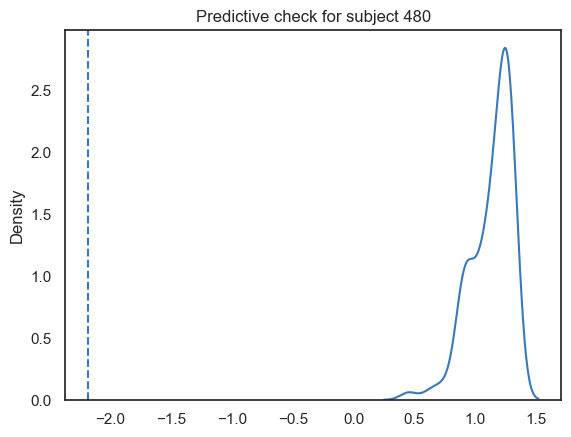

In [29]:
subject_no = npr.choice(holdout_subjects) 
sns.kdeplot(rep_ll_per_zi[:,subject_no]).set_title("Predictive check for subject "+str(subject_no))
plt.axvline(x=obs_ll_per_zi[subject_no], linestyle='--')

## Step 3: Correct for the substitute confounder in a causal inference.

**How** to estimate causal effects?

*  For simplicity, we fit a logistic regression as an outcome model here. 

*  The target is the observed outcome $y_n$, $n=1,\ldots, N$.

*  The regressor is the multiple causes $\mathbf{X}_n$, $n=1,\ldots, N$.

**How** to correct for the substitute confounder?

*  We include the substitute confounder $\mathbf{Z}_n$, $n=1,\ldots, N$, into the regressors.

In [30]:
# approximate the (random variable) substitute confounders with their inferred mean.
Z_hat = z_mean_inferred 
# augment the regressors to be both the assigned causes X and the substitute confounder Z
X_aug = np.column_stack([X, Z_hat])

In [31]:
# holdout some data from prediction later
X_train, X_test, y_train, y_test = train_test_split(X_aug, dfy, test_size=0.2, random_state=0)

In [32]:
dcfX_train = sm.add_constant(X_train)
dcflogit_model = sm.Logit(y_train, dcfX_train)
dcfresult = dcflogit_model.fit_regularized(maxiter=5000)
print(dcfresult.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.132869761545909
            Iterations: 85
            Function evaluations: 85
            Gradient evaluations: 85
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           10
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.7971
Time:                        00:32:53   Log-Likelihood:                -60.456
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 9.348e-96
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [33]:
res = pd.DataFrame({"causal_mean": dcfresult.params[:data_dim+1], \
                  "causal_std": dcfresult.bse[:data_dim+1], \
                  "causal_025": dcfresult.conf_int()[:data_dim+1,0], \
                  "causal_975": dcfresult.conf_int()[:data_dim+1,1], \
                   "causal_pval": dcfresult.pvalues[:data_dim+1]})
res["causal_sig"] = (res["causal_pval"] < 0.05)
res = res.T
res.columns = np.concatenate([["intercept"], np.array(dfX.columns)])
res = res.T

In [34]:
res

,causal_mean,causal_std,causal_025,causal_975,causal_pval,causal_sig
intercept,0.799657,0.260116,0.289839,1.30947,0.00211043,True
mean radius,-2.97783,0.964373,-4.86796,-1.08769,0.0020162,True
mean texture,-1.44867,0.380799,-2.19502,-0.702313,0.000142218,True
mean smoothness,-1.46326,0.743651,-2.92079,-0.00573425,0.0491055,True
mean compactness,0.368069,0.87232,-1.34165,2.07778,0.673067,False
mean concavity,-1.13524,0.90044,-2.90007,0.629588,0.207394,False
mean concave points,-1.65108,1.23964,-4.08072,0.778573,0.182893,False
mean symmetry,-0.536826,0.506479,-1.52951,0.455855,0.289182,False
mean fractal dimension,0.416358,0.765082,-1.08318,1.91589,0.586304,False


We check the predictions to see if the logistic outcome model is a good outcome model.

In [35]:
# make predictions with the causal model 
dcfX_test = X_test
dcfy_predprob = dcfresult.predict(sm.add_constant(dcfX_test))
dcfy_pred = (dcfy_predprob > 0.5)
print(classification_report(y_test, dcfy_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        47
           1       0.94      0.97      0.96        67

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114



# We are done!

We have computed the average causal effect of raising the causes by one unit (see the "causal mean" column above).

# Is the deconfounder worth the effort?

We finally compare the **causal** estimation (with the deconfounder) with the **noncausal** estimation (with vanilla regression).

## The classical logistic regression! Note it is noncausal :-(

In [36]:
# regress the outcome against the causes only (no substitute confounders)
nodcfX_train = sm.add_constant(X_train[:,:X.shape[1]])
nodcflogit_model = sm.Logit(y_train, nodcfX_train)
nodcfresult = nodcflogit_model.fit_regularized(maxiter=5000)
print(nodcfresult.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13451539390572878
            Iterations: 71
            Function evaluations: 71
            Gradient evaluations: 71
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            8
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.7946
Time:                        00:32:53   Log-Likelihood:                -61.205
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 3.283e-97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [37]:
res["noncausal_mean"] = np.array(nodcfresult.params)
res["noncausal_std"] = np.array(nodcfresult.bse)
res["noncausal_025"] = np.array(nodcfresult.conf_int()[:,0])
res["noncausal_975"] = np.array(nodcfresult.conf_int()[:,1])
res["noncausal_pval"] = np.array(nodcfresult.pvalues)
res["noncausal_sig"] = (res["noncausal_pval"] < 0.05)

In [38]:
res["diff"] = res["causal_mean"] - res["noncausal_mean"]
res["pval_diff"] = res["causal_pval"] - res["noncausal_pval"]

In [39]:
nodcfX_test = sm.add_constant(X_test[:,:X.shape[1]])
nodcfy_predprob = nodcfresult.predict(nodcfX_test)
nodcfy_pred = (nodcfy_predprob > 0.5)

**Causal models do not hurt predictions here!**

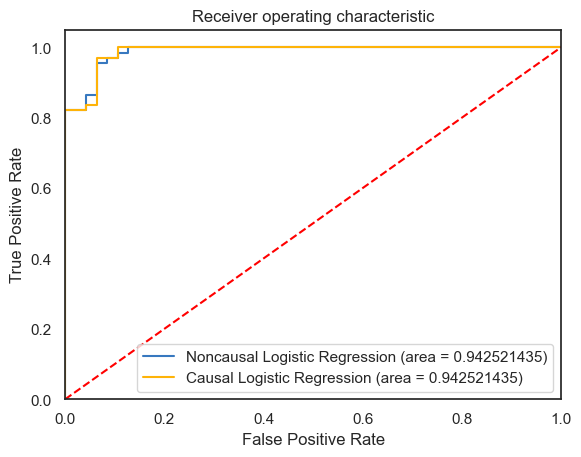

In [40]:
dcflogit_roc_auc = roc_auc_score(y_test, dcfy_pred)
dcffpr, dcftpr, dcfthresholds = roc_curve(y_test, dcfy_predprob)
nodcflogit_roc_auc = roc_auc_score(y_test, nodcfy_pred)
nodcffpr, nodcftpr, nodcfthresholds = roc_curve(y_test, nodcfy_predprob)
plt.figure()
plt.plot(nodcffpr, nodcftpr, label='Noncausal Logistic Regression (area = %0.9f)' % nodcflogit_roc_auc)
plt.plot(dcffpr, dcftpr, label='Causal Logistic Regression (area = %0.9f)' % dcflogit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**But causal models do change the regression coefficients and which features are significant.**

*   The mean smoothness is a feature **significantly correlated** with the cancer diagnosis.

*   But it does **not significantly** **causally affect** the cancer diagnosis.

*   The effect of all features are **over-estimated** with the noncausal model except the "mean compactness".

In [41]:
res.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
mean compactness,-0.00130945,0.673067,6.743764e-01,False,False,0.368069,0.311494
intercept,-0.00060616,0.00211043,2.716595e-03,True,True,0.799657,0.763172
mean texture,0.000142197,0.000142218,2.123746e-08,True,True,-1.44867,-1.718860
mean radius,0.00171102,0.0020162,3.051830e-04,True,True,-2.97783,-3.264181
mean smoothness,0.0352701,0.0491055,1.383540e-02,True,True,-1.46326,-1.225668
mean concavity,0.0927253,0.207394,1.146687e-01,False,False,-1.13524,-1.131677
mean concave points,0.0963094,0.182893,8.658376e-02,False,False,-1.65108,-2.007921
mean fractal dimension,0.192521,0.586304,3.937831e-01,False,False,0.416358,0.577489
mean symmetry,0.194775,0.289182,9.440683e-02,False,False,-0.536826,-0.541292


*   We include causes into the regression **one-by-one**.
*   The deconfounder coefficients **does not** flip signs.
*   But classical logistic regression coefficients **does** flip signs.
*   This suggests that **the deconfounder is causal**. 
*   It is because **causal** coefficients **do not change** as we include more variables into the system; causal estimation already controls for confounders so that it is causal.
*   However, **correlation** coefficients **can change** as we include more variables into the system; if the added variable is a confounder, than the regression coefficients change to account for the confounding effects.

In [42]:
# The deconfounder with causes added one-by-one
# The first i coefficient is the causal coefficient of the first i causes.
# i = 1, ..., 8.
for i in range(X.shape[1]):
    print(i, "causes included")
    # augment the regressors to be both the assigned causes X and the substitute confounder Z
    X_aug = np.column_stack([X[:,:i], Z_hat])
    # holdout some data from prediction later
    X_train, X_test, y_train, y_test = train_test_split(X_aug, dfy, test_size=0.2, random_state=0)
    dcfX_train = sm.add_constant(X_train)
    dcflogit_model = sm.Logit(y_train, dcfX_train)
    dcfresult = dcflogit_model.fit_regularized(maxiter=5000)
    print(dcfresult.summary())    

0 causes included
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1848023081769142
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.7178
Time:                        00:32:53   Log-Likelihood:                -84.085
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 1.267e-93
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [43]:
# Logistic regression with causes added one-by-one
# The first i coefficient is the causal coefficient of the first i causes.
# i = 1, ..., 8.
for i in range(X.shape[1]):
    print(i, "causes included")
    # augment the regressors to be both the assigned causes X and the substitute confounder Z
    X_aug = np.column_stack([X[:,:i]])
    # holdout some data from prediction later
    X_train, X_test, y_train, y_test = train_test_split(X_aug, dfy, test_size=0.2, random_state=0)
    dcfX_train = sm.add_constant(X_train)
    dcflogit_model = sm.Logit(y_train, dcfX_train)
    dcfresult = dcflogit_model.fit_regularized(maxiter=5000)
    print(dcfresult.summary())    

0 causes included
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6549205599225008
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            0
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:               7.357e-13
Time:                        00:32:53   Log-Likelihood:                -297.99
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

**We note that the causal coefficient of x4 is stable with the (causal) deconfounder but the correlation coefficent of x4 flips sign with the (noncausal) logistic regression.**

# Takeaways



*   The deconfounder is **not hard** to use.
*   We simply **fit** a factor model, **check** it, and **infer** causal effects with the substitute confounder.
*   Please **always check** the factor model.
*   The deconfounder **makes a difference**.
*   The deconfounder **deconfounds**.



# Acknowledgements

We thank Suresh Naidu for suggesting the adding-causes-one-by-one idea.